# Excersize: Use KNN on your descriptors

- How about we try KNN regressor on our descriptors for concrete as well 

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
import math
#import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

In [15]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    
    # we want w (weigths) from Xw = y
    # do some linear algebra to isolate w

    XTX = X.T.dot(X) # Gram matrix, makes X into a square matrix by multiplying it by its transpose
    XTX_inv = np.linalg.inv(XTX) # invert the gram matrix
    w = XTX_inv.dot(X.T).dot(y) # now can solve for w from Xw = y
    
    return w[0], w[1:]

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def rmse(y, y_pred):
    # for each predicted value, find difference between it and actual
    error = y_pred - y
    # now square this error, and calculate the mean
    mse = (error**2).mean()
    # return the squar-rooted mse
    return np.sqrt(mse)

In [16]:
base = ['cement', 'slag', 'flyash', 'water', 'age', 'superplasticizer', 
        'coarseaggregate', 'fineaggregate']
df=pd.read_csv('Concrete_Data_Yeh.csv')

n_val = int(len(df)*0.2)
n_test = int(len(df)*0.2)
n_train = len(df) - n_val - n_test

np.random.seed(2)
idx = np.arange(len(df))
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = df.iloc[idx[n_train+n_val:]].copy()

y_train = np.array(df_train.csMPa.values)
y_val = np.array(df_val.csMPa.values)
y_test = np.array(df_test.csMPa.values)

del df_train['csMPa']
del df_val['csMPa']
del df_test['csMPa']

X_test = prepare_X(df_test)
X_val = prepare_X(df_val)
X_train = prepare_X(df_train)

In [17]:
# here we use knn regressor
# gridsearch will help us find best number of neighbors to use

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
knn=KNeighborsRegressor()
parameters={'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,20,30,40]}
knn_regressor=GridSearchCV(knn,parameters,scoring='neg_mean_squared_error',cv=5)
knn_regressor.fit(X_train,y_train)
print(knn_regressor.best_params_)
print('Train RMSE:',math.sqrt(-1.0*knn_regressor.best_score_))

{'n_neighbors': 6}
Train RMSE: 10.336667763498355


- Here the best number of neighbors according to my given values is 6
- Not a bad RMSE compared to the others I have gotten with other methods such as linear regression and lasso, about the same
- Other than KRR which gave the best out of all so far by a lot according to RMSE
- Let's go ahead and just plot this against our linear regression model

In [18]:
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_test.dot(w)

prediction_knn = knn_regressor.predict(X_test)

print('Linear Regression RMSE test set:' , rmse(y_test, y_pred))
print('KNN RMSE test set:' , math.sqrt(-1.0*knn_regressor.score(X_test,y_test)))

Linear Regression RMSE test set: 10.217404223197772
KNN RMSE test set: 9.419528735660917


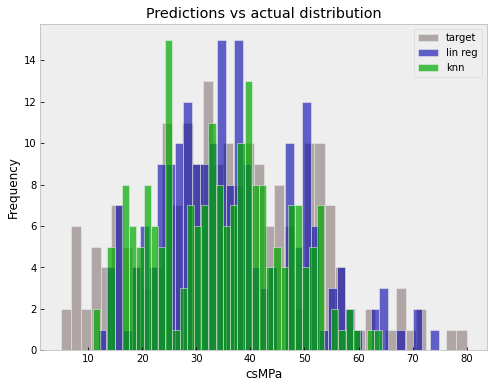

In [33]:
plt.figure(figsize=(8, 6))

sns.histplot(y_test, label='target', color='#220000', alpha=0.3, bins=40)
sns.histplot(y_pred, label='lin reg', color='#0000aa', alpha=0.6, bins=40)
sns.histplot(prediction_knn, label='knn', color='#00aa00', alpha=0.7, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('csMPa')
plt.title('Predictions vs actual distribution')
plt.grid(visible=None)
plt.show()

- So, despite a smaller RMSE value given by the KNN vs linear regression, the places where KNN gets a good fit is different from linear regression, so its hard to know which is better

# 3/2 Unsupervised Learning, Clustering

# Exercise: Use Kmeans clustering

In [6]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
#import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import seaborn as sns
# here we set the style of the plots that will be shown below
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,6)
title_size=24

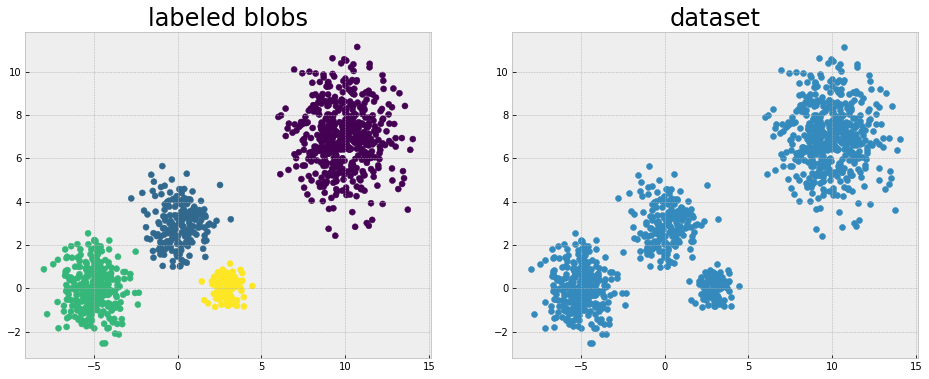

In [2]:
# We set a random_state to generate always the same Gaussian sampling.
random_state = 0
# The make_blobs function requires the centers, standard deviations and number of samples for each Gaussian to sample.
centers = [[10,7],[0,3],[-5,0],[3,0]]
n_samples = [500,200,300,100]
cluster_std=[1.5,1,1,0.5]
     
X_blobs, y_blobs = make_blobs(n_samples=n_samples,
                   random_state=random_state,
                   cluster_std=cluster_std,
                   centers=centers)

fig, axs = plt.subplots(1,2,figsize=[16,6])
axs[0].scatter(X_blobs[:,0],X_blobs[:,1],c=y_blobs)
axs[0].set_title('labeled blobs', size=title_size)
axs[1].scatter(X_blobs[:,0],X_blobs[:,1])
axs[1].set_title('dataset', size=title_size)

plt.show();

In [3]:
# now we will import the Kmeans algorithm from sklearn
from sklearn.cluster import KMeans

In [4]:
# fit our data
# n_clusters is the number of clusters we aim to make
# so we actually need to test out different numbers of clusters
# n_init is the number of times the algorithm runs with different centroid seeds
# Kmeans seeks to minimize the inertia of clusters, or the sum 
# of distances between the mean of a cluster and each point within it
# a measure of how 'coherent' a cluster is

kmeans = KMeans(n_clusters=4,n_init=10).fit(X_blobs)
kmeans.predict

<bound method KMeans.predict of KMeans(n_clusters=4)>

In [5]:
pred_centers = kmeans.cluster_centers_
labels = kmeans.labels_

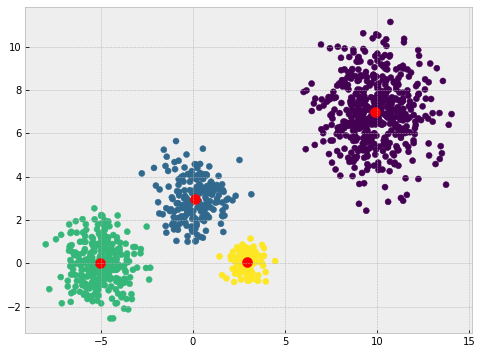

In [6]:
# here is a plot of the clusters with the predicted centers

fig, axs = plt.subplots(1,1)
axs.scatter(X_blobs[:,0],X_blobs[:,1],c=y_blobs)
axs.scatter(pred_centers[:,0],pred_centers[:,1],s=100,c='red')

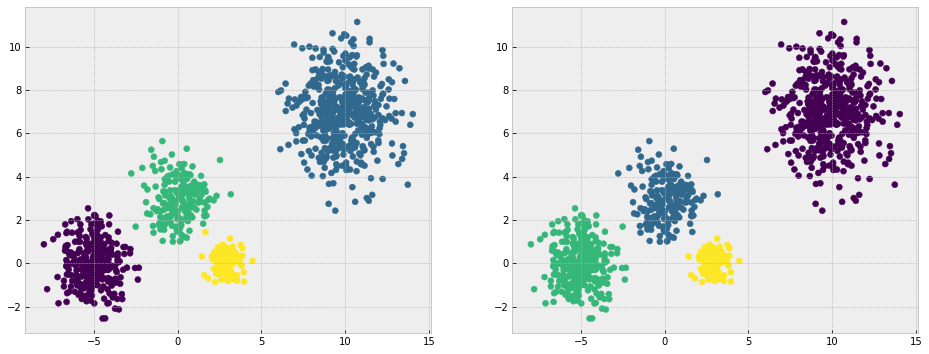

In [11]:
# and here is a plot of the predicted labels for every point
# along with what the actual labels were

fig, axs = plt.subplots(1,2,figsize=[16,6])
axs[0].scatter(X_blobs[:,0],X_blobs[:,1],c=labels)
axs[1].scatter(X_blobs[:,0],X_blobs[:,1],c=y_blobs)

- Note, the color difference does not matter, look just at how the points were clustered
- Matches the actual except for a couple points between the three clusters in bottom left corner

- The Kmeans algorithm works best on spherical convex and similar sized clusters
- Here, we also knew we wanted 4 clusters, so a drawback is requiring us to know a little about how it should be clustered
- It is always possible you lack some amount of data that makes it appear you have more clusters than you should

# Exercise: Use KNN clustering

- First we will use the blobs we created in the previous excersize
- We get each point's coordinates (X_blobs) and each point's label corresponding to which group it belongs (y_blobs)

In [34]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
import math
#import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
# here we set the style of the plots that will be shown below
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,6)
title_size=24

# We set a random_state to generate always the same Gaussian sampling.
random_state = 0
# The make_blobs function requires the centers, standard deviations and number of samples for each Gaussian to sample.
centers = [[10,7],[0,3],[-5,0],[3,0]]
n_samples = [500,200,300,100]
cluster_std=[1.5,1,1,0.5]
     
X_blobs, y_blobs = make_blobs(n_samples=n_samples,
                   random_state=random_state,
                   cluster_std=cluster_std,
                   centers=centers)

In [35]:
X_blobs

array([[-0.91965069,  5.64293572],
       [ 8.58344726,  7.35715472],
       [-4.9746144 ,  0.61039176],
       ...,
       [11.40466859,  6.94735723],
       [ 9.70240165,  7.14128845],
       [ 8.81699612,  8.64195756]])

In [36]:
y_blobs

array([1, 0, 2, ..., 0, 0, 0])

- Now we use sklearn KNN algorithm
- We give it a k value, number of nearest neighbors to look at to determine a point's group
- We fit the model onto the clusters made in our training set
- We fit to the location of each point and each point's group label

In [37]:
#from sklearn.neighbors import KNeighborsRegressor

#knn=KNeighborsRegressor(n_neighbors=4)
#knn.fit(X_blobs, y_blobs)

In [38]:
# we use gridsearchcv to help us determine best number of neighbors to use

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn=KNeighborsClassifier()
parameters={'n_neighbors':[1,2,3,4,5,6]}
knn_classifier=GridSearchCV(knn,parameters,scoring='neg_mean_squared_error',cv=5)
knn_classifier.fit(X_blobs,y_blobs)
print(knn_classifier.best_params_)
print(math.sqrt(-1.0*knn_classifier.best_score_))

{'n_neighbors': 1}
0.03015113445777636


- the value for k was chosen by gridsearchcv, it did the cross validation for me
- Now we can use the model to predict which grouping a new point belongs in our dataset

Text(0.5, 1.0, 'actual')

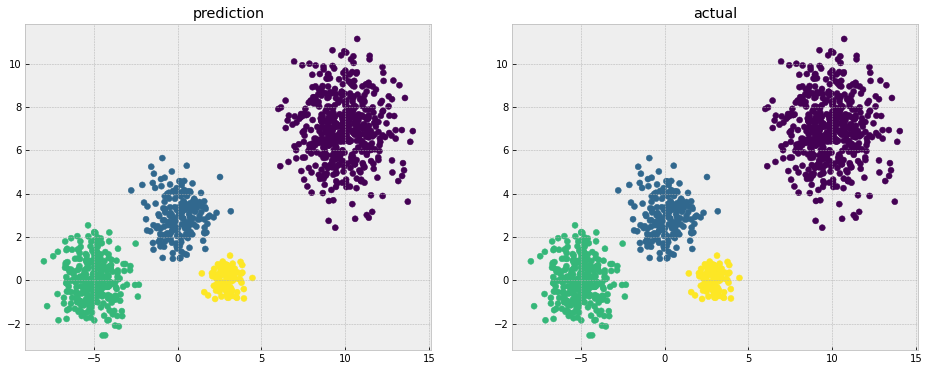

In [39]:
# let's plot the predicted points with labels vs actual
# first get all the predicted labels for X_blobs

labels = knn_classifier.predict(X_blobs)

# now plot

fig, axs = plt.subplots(1,2,figsize=[16,6])
axs[0].scatter(X_blobs[:,0],X_blobs[:,1],c=labels)
axs[0].set_title('prediction')
axs[1].scatter(X_blobs[:,0],X_blobs[:,1],c=y_blobs)
axs[1].set_title('actual')

- Looks like it did a good job, let's see what checking a single point is like...

In [40]:
knn_classifier.predict([[1,2]])

array([1])

- This is telling us that the point (1,2) belongs to group 1 according to the model

In [41]:
# here I create a new y_blobs list that sets all labels not equal to 1 to zero
# this will help reveal which cluster corresponds to label 1
yy = y_blobs
for i in range(len(y_blobs)):
    if yy[i] != 1:
        yy[i] = 0

- Plot the clusters, cluster 1 is yellow, all others purple
- Red dot is point we are predicting to be part of group 1

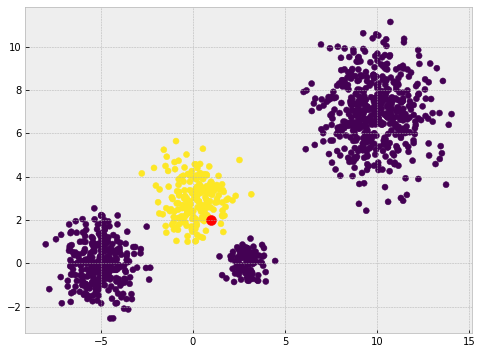

In [42]:
fig, axs = plt.subplots(1,1)
axs.scatter(X_blobs[:,0],X_blobs[:,1],c=yy)
axs.scatter([1],[2],s=100,c='red')

- Seems like a reasonable prediction

# 3/7: Principal component analysis
# Perform PCA on concrete data

In [35]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [36]:
df=pd.read_csv('Concrete_Data_Yeh.csv')
target = df.csMPa.values
del df['csMPa']
X = df.values
X.shape

(1030, 8)

- So we have eight descriptors here that we will do pca on

In [37]:
# We need to normalize data so that any descriptor's individual scaling will not
# make it appear to be more important than it really is

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [41]:
from sklearn.decomposition import PCA # within the scikit-learn module which focuses on
                                      # Machine Learning in Python, we import PCA decomposition algorithm
pca8 = PCA(n_components=5)            # applies PCA with the argument that we want a two-component fit
pca8.fit(X_scaled)                           # fits the PCA model with dataset X defined above
print(pca8)                          # this is only the PCA object!
X_pca8 = pca8.transform(X_scaled)

# The fit learns some quantities from the data, namely the "components" and "explained variance"
# In this example, there are two sets of components to be described below

print('components: ' + str(pca8.components_))                 # each component defined by x-y pair
print('explained variance: ' + str(pca8.explained_variance_)) # how much variance each component explains 
                                                              # taking into consideration the entire dataset
print('cummulative explained variance: ' + str(round(sum(pca8.explained_variance_),3)))
print('ratio: ', sum(pca8.explained_variance_ratio_ * 100))

PCA(n_components=5)
components: [[ 0.09840137  0.17726197 -0.39466185  0.54700395 -0.50594541  0.03792808
  -0.40192597  0.29147949]
 [-0.11373709  0.6860529  -0.14294751  0.05325628  0.2829296  -0.62994342
  -0.01939111 -0.12598089]
 [ 0.81420224 -0.17179437 -0.40822055 -0.21318975  0.23459653 -0.17408781
  -0.00456921  0.10052137]
 [-0.054297   -0.36269932  0.2267512   0.29606003 -0.03727351 -0.54580513
   0.38528206  0.52791909]
 [ 0.14820612 -0.02093167  0.54963115  0.07022191  0.35461841 -0.03308317
  -0.70123743  0.22801019]]
explained variance: [2.2823152  1.41745097 1.34138135 1.01514445 0.95243269]
cummulative explained variance: 7.009
ratio:  87.52400072178591


- So let's do this for 1 to 8 components and see how the total variance increases as we include more components in the fit

In [47]:
total_var_list = np.array([])
for i in range(8):
    pca8 = pca8 = PCA(n_components=i+1) 
    pca8.fit(X_scaled)
    total_var_list = np.append(total_var_list, sum(pca8.explained_variance_ratio_ * 100))
print(total_var_list)

[ 28.50124202  46.20217702  62.95316494  75.6301508   87.52400072
  97.40144413  99.62446526 100.        ]


Text(0, 0.5, 'total variance')

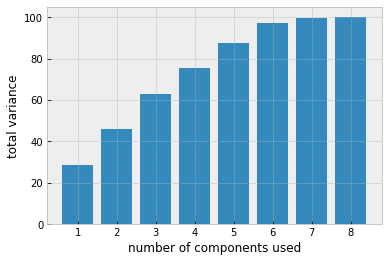

In [57]:
plt.bar(np.arange(8)+1, total_var_list)
plt.xlabel('number of components used')
plt.ylabel('total variance')

- So if we were looking for at least 80 percent variance represented, we would be good with only 5 total components used

# 3/9 Use NOMAD to build a dataset

- We will decide on descriptors, use these to query the NOMAD database and return some entries to build a dataset from

- Let's look for structures that contain Aluminum and Iron
- Let's have the symmetry be Tetragonal, Hexagonal, or Cubic so that magnetic ordering may be degenerate
- Let's require the entries to contain density of states

- below we use the API to create a json file with all the requested information from NOMAD

In [3]:
import requests
import json

base_url = 'http://nomad-lab.eu/prod/v1/api/v1'

response = requests.post(
    f'{base_url}/entries/query',
    json={
  "owner": "visible",
  "query": {
    "results.material.symmetry.crystal_system:any": [
      "tetragonal",
      "hexagonal",
      "cubic"
    ],
    "results.material.elements:all": [
      "Al",
      "Fe"
    ],
    "results.properties.available_properties:all": [
      "dos_electronic"
    ]
  },
    'pagination': {
        'page_size': 500
    }
})
response_json = response.json()
print(json.dumps(response.json(), indent=2))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



- Looks like we have a data rate problem, let's try to decrease the amount of data that I download
- Do this by using 'required'. This returns only the data asked for.
- Let us request the chemical formula, crystal symmetry, method used to solve, and whether spin polarized

In [61]:
import requests
import json

base_url = 'http://nomad-lab.eu/prod/v1/api/v1'

response = requests.post(
    f'{base_url}/entries/query',
    json={
  "owner": "visible",
  "query": {
    "results.material.symmetry.crystal_system:any": [
      "tetragonal",
      "hexagonal",
      "cubic"
    ],
    "results.material.elements:all": [
      "Al",
      "Fe"
    ],
    "results.properties.available_properties:all": [
      "dos_electronic"
    ]
  },
    'pagination': {
        'page_size': 2000
    },
      'required': {
        'include': [
                    'results.material.chemical_formula_hill',
                    'results.material.symmetry.crystal_system',
                   'results.method.simulation.dft.spin_polarized',
                    'results.method.method_name'
        ]
    }
})
response_json = response.json()
print(json.dumps(response.json(), indent=2))

{
  "owner": "visible",
  "query": {
    "and": [
      {
        "name": "results.material.symmetry.crystal_system",
        "value": {
          "any": [
            "tetragonal",
            "hexagonal",
            "cubic"
          ]
        }
      },
      {
        "name": "results.material.elements",
        "value": {
          "all": [
            "Al",
            "Fe"
          ]
        }
      },
      {
        "name": "results.properties.available_properties",
        "value": {
          "all": [
            "dos_electronic"
          ]
        }
      }
    ]
  },
  "pagination": {
    "page_size": 2000,
    "order_by": "entry_id",
    "order": "asc",
    "total": 8040,
    "next_page_after_value": "F8Gyhqy7iCTdoy7sWu27EjmTywse"
  },
  "required": {
    "include": [
      "results.material.chemical_formula_hill",
      "results.material.symmetry.crystal_system",
      "results.method.simulation.dft.spin_polarized",
      "results.method.method_name",
      "entry_id"

- So now we are returned only a few bits of information on each entry that matches our query in the NOMAD database
- We can put this information into a pandas dataframe with the following

In [62]:
import pandas as pd

df = pd.json_normalize(response_json['data'])
df.head()

,entry_id,results.material.symmetry.crystal_system,results.material.chemical_formula_hill,results.method.method_name
0,--E_7HYPtN1ydjJizq5xMEfLugXu,cubic,AlCoFe2,DFT
1,--Vn9V7BSo59f5VCZ5aRgGza6Oj-,tetragonal,Al2FeSe,DFT
2,--b95Low5pFrzWfe1PcFpl0tV_1f,cubic,AlFe2V,DFT
3,-03XFhmDi6gDBBPjaveUPYFR3nbh,cubic,AlCrFeTl,DFT
4,-0ErlNM9QTyWI1jf5UtRSdh81WRp,cubic,AlFeMoTi,DFT


## Exercise: Use SVM on a binary dataset

- use the dataset we created earlier where we transformed our concrete data into 0 and 1s

In [1]:
# here is example of how this works
# pipeline is a way to condense multiple different functions you want to use on your data

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
print(clf.predict([[-0.8, -1]]))

[1]


- So we will setup our concrete data
- We will start with a value of csMPa > 45 to determine if concrete is good or bad
- Can tweak as needed, along with the lengths of each data split

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    
    # we want w (weigths) from Xw = y
    # do some linear algebra to isolate w

    XTX = X.T.dot(X) # Gram matrix, makes X into a square matrix by multiplying it by its transpose
    XTX_inv = np.linalg.inv(XTX) # invert the gram matrix
    w = XTX_inv.dot(X.T).dot(y) # now can solve for w from Xw = y
    
    return w[0], w[1:]

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def rmse(y, y_pred):
    # for each predicted value, find difference between it and actual
    error = y_pred - y
    # now square this error, and calculate the mean
    mse = (error**2).mean()
    # return the squar-rooted mse
    return np.sqrt(mse)

df=pd.read_csv('./Concrete_Data_Yeh.csv')

# let's make a new category for 'good' vs. 'bad' concrete
# do this by having good be csMPa > 45.0
# also have a category of flyash---> yes or no

df['goodconcrete']=(df.csMPa>45.0).astype(int)
# now delete the actual values for csMPa
# the target values are now categorical
del df['csMPa']

# here we give condition that concrete has flyash
#df['flyash']=(df.flyash>5.0)
# and replace the boolean with yes or no
#df['flyash'] = df['flyash'].replace({True: 'yes', False: 'no'})

#now that we have created these new categorical columns, we can split our dataset

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=104,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.goodconcrete.values
y_val = df_val.goodconcrete.values
y_test = df_test.goodconcrete.values

# get rid of target values in training data
del df_train['goodconcrete']
del df_val['goodconcrete']
del df_test['goodconcrete']

base = ['cement', 'slag','flyash', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']
df.head()
print(len(df_train),len(df_test),len(df_val))

618 206 206


- Now we try to use SVM on this dataset
- Use a polynomial kernel
- We need to optimize the dimensionality paramater using cross validation

In [3]:
# here I am using the validation dataset to train my model
# this is because the training dataset is too large as it was partitioned above
# the calculation takes a long time, very long time
# the calculation seems very sensitive to number of inputs

X_test = prepare_X(df_test)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters={'degree':[1,2,3,4,5,6]}
clf = SVC(kernel = 'poly', gamma='auto')
svm_clf = GridSearchCV(clf,parameters,scoring='accuracy',cv=5)
svm_clf.fit(X_val, y_val)
print(svm_clf.best_params_)

{'degree': 2}


In [4]:
# this tells us how well one set of data agrees with another, percentage
from sklearn.metrics import accuracy_score

# let's see how well our model works on predicting the test dataset
prediction_test = svm_clf.predict(X_test)

accuracy_score(y_test, prediction_test)

0.8446601941747572

- Now we will try out the radial basis function instead of polynomial

In [5]:
svm_clf = SVC(kernel = 'rbf', gamma='auto')
svm_clf.fit(X_val, y_val)
prediction_test = svm_clf.predict(X_test)
accuracy_score(y_test, prediction_test)

0.7038834951456311

- Now, let's try to demonstrate how to use pipeline on this process
- Use polynomial kernel

In [13]:
#scaler = StandardScaler()
#pipe = make_pipeline(StandardScaler(), SVC(kernel = 'poly', gamma='auto'))
#svm_clf = GridSearchCV(pipe,parameters,scoring='accuracy',cv=5)
#svm_clf.fit(X, y)

#prediction_test = svm_clf.predict(X_test)

#accuracy_score(y_test, prediction_test)

# Notes 3/23

- First we need to setup our logistic regression
- Then we will demonstrate how testing for accuracy works

In [13]:
# Notes 3/23

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    
    # we want w (weigths) from Xw = y
    # do some linear algebra to isolate w

    XTX = X.T.dot(X) # Gram matrix, makes X into a square matrix by multiplying it by its transpose
    XTX_inv = np.linalg.inv(XTX) # invert the gram matrix
    w = XTX_inv.dot(X.T).dot(y) # now can solve for w from Xw = y
    
    return w[0], w[1:]

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def rmse(y, y_pred):
    # for each predicted value, find difference between it and actual
    error = y_pred - y
    # now square this error, and calculate the mean
    mse = (error**2).mean()
    # return the squar-rooted mse
    return np.sqrt(mse)

df=pd.read_csv('./Concrete_Data_Yeh.csv')

# let's make a new category for 'good' vs. 'bad' concrete
# do this by having good be csMPa > 45.0
# also have a category of flyash---> yes or no

df['goodconcrete']=(df.csMPa>45.0).astype(int)
# now delete the actual values for csMPa
# the target values are now categorical
del df['csMPa']

# here we give condition that concrete has flyash
df['flyash']=(df.flyash>5.0)
# and replace the boolean with yes or no
df['flyash'] = df['flyash'].replace({True: 'yes', False: 'no'})

df.head()

#now that we have created these new categorical columns, we can split our dataset

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=104,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.goodconcrete.values
y_val = df_val.goodconcrete.values
y_test = df_test.goodconcrete.values

# get rid of target values in training data
del df_train['goodconcrete']
del df_val['goodconcrete']
del df_test['goodconcrete']

print(len(df_val)/len(df),len(df_test)/len(df),len(df_train)/len(df))

global_mean = df_train_full.goodconcrete.mean()
round(global_mean, 3)

# let's find the mean value of 'goodconcrete' given the subset of only 'yes' flyash
flyyes_mean = df_train_full[df_train_full.flyash == 'yes'].goodconcrete.mean()
print('flyash == yes:', round(flyyes_mean, 3))

# same thing but for subset of 'no' flyash
flyno_mean = df_train_full[df_train_full.flyash == 'no'].goodconcrete.mean()
print('flyash == no:  ', round(flyno_mean, 3))

# these values are essentially the percent of concrete considered good in these subsets

# we can also look at the mean value of good concrete for a subset 
# with a conditional on a different category than the ones we made binary
# here is one for water content

df_train_full[df_train_full.water < 200].goodconcrete.mean()

# combine multiple conditionals to create a new subset
df_train_full[(df_train_full.water < 200)&(df_train_full.water > 170)].goodconcrete.mean()

## Mutual information and correlation
# How can we determine how much we know about one feature based on another?
# Mutual information
# let's see how well our categorical data for flyash describes our categorical data for good concrete

from sklearn.metrics import mutual_info_score
# it can be useful to define a function for this
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.goodconcrete)

categorical = ['flyash']
# we can enact our function on a subset of data with '.apply(calculate_mi)'
df_mi = df_train_full[categorical].apply(calculate_mi)
#df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

# The absolute value here given for mutual information score is hard to interpret on its own
# Easier when other scores from other categorical features are compared
# However we previously know that 'flyash' seems to be a bad predictor for 'goodconcrete'
# Therefore this small number definitely shows us this is a weak correlation
# Weak correlation... let's see how the other variables fair against our target of 'goodconcrete'
# Instead of using mutual_info_score, let's find the correlation using '.corrwith()'

# create a new frame with column header by using option '.to_frame('name_of_column')'
numerical=['cement', 'slag', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']
df_train_full[numerical].corrwith(df_train_full.goodconcrete).to_frame('correlation')

# Larger correlation is closer to -1 or 1
# Negative correlation, one increases the other decreases (becomes less likely)
# So 'cement' value seems to correlate relatively strongly with 'goodconcrete'
# water tends to make concrete 'bad'

## One hot encoding

# break up categorical data into further categories
# Take each possibility from a category, make each possibility its own category
# have those categories just be boolean, True of False
# each of these categories are sub categories of the original category

from sklearn.feature_extraction import DictVectorizer

# let's take all of our features of train dataset and make records
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

#dv.get_feature_names_out()

# So we see how the only value that gets separated is 'flyash=no' and 'flyash=yes'
# The other values are all numerical so they can't be separated into new categories

# this shows us all of our columns with respective values
dv.transform(train_dict)

# set a variable to hold the new columns of the one-hot coded data
# the only thing really affected was the column for flyash
X_train = dv.transform(train_dict)

# size varies based on how much of dataset we gave to train set
X_train.shape

## Logistic Regression

# this is in comparison to linear regression as a predictor

# for binary classification, our target can only be 1 and 0's

# very similar to linear regression, takes the same formula
# puts the formula through SIGMOID which gives values between 0 and 1 instead
# of -infinity and +infinity for our prediction of a target
# works very well for binary data, like our 'goodconcrete' target
# makes our predictions either 0s or 1s so it is easier to compare to test data
# otherwise our model will give us values between 0 and 1, harder to compare then

# we can manually do the sigmoid...
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5,5,20)
sigmoid(z)
# see how this gives us numbers between 0 and 1 from an input of numbers between -5 and 5

# So, negative numbers tend towards zero when put through sigmoid
# Positive numbers tend towards 1
# Sigmoid essentially takes a score and turns it into a probability

## Logistic Regression with Scikit

# We will run predictions using test set rather than just train set
# Dataset created above in one hot encoding

from sklearn.linear_model import LogisticRegression

# create the model, apply it to our one-hot coded training dataset
# see above for the training set we created used here
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

# now here are the weights for each feature
model.coef_

# So now we have our trained model, using our training dataset
# Now let's test our model on predicting the testing dataset

# now we one-hot code our test dataset, so we can feed it into our model to test its accuracy
test_dict = df_test[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test = dv.transform(test_dict)

# here are hard predictions, we don't know certainty
model.predict(X_test)

# here are soft predictions, the probabilities rather than just 0 or 1, its a score now
# first column is probability of being negative (tending towards 0 from sigmoid)
# second column is probability of being positive (tending towards 1 from sigmoid)
model.predict_proba(X_test)

# So, for this dataset we have the probability of being bad concrete left column, or good concrete in right column

# let's take all rows, but only take the probability of being good concrete
y_pred = model.predict_proba(X_test)[:, 1]

# so, we can make our prediction of good concrete based on whether or not
# our predicted target score is above 0.5, indicating a tendency towards 1
# which means concrete deemed 'good'
good_concrete = (y_pred >= 0.5)

# For linear regression we used rmse as a determination of model effectiveness
# Here we do something similar, called accuracy
# See how well we predicted that we should have 'good' concrete

# let's see the accuracy of our model for predicting the test data target
(y_test == good_concrete).mean()

0.2 0.2 0.6
flyash == yes: 0.224
flyash == no:   0.271


0.8155339805825242

# Ok, now onto the current lecture content
## Exercise: Find accuracy of trained model

- Find accuracy for threshold of 0.5, meaning we say that values of 0.5 and above in our prediction means good concrete
- We are using the code from above for logistic regression model

In [15]:
# this tells us how well one set of data agrees with another, percentage
from sklearn.metrics import accuracy_score

In [16]:
# first we say what values in our prediction will be considered good concrete
good_concrete = (y_pred >= 0.5)
# convert boolean to binary
good_concrete = good_concrete*1

In [17]:
# here we find how much our model agrees with what we considered actually good concrete
accuracy_score(y_test, good_concrete)

0.8155339805825242

- Now let's say that only concrete with a value of exactly 1 or above in our prediction is good
- This means that we are saying that none of the concrete is good in our prediction

In [18]:
good_concrete = (y_pred >= 1)
good_concrete = good_concrete*1
good_concrete

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
accuracy_score(y_test, good_concrete)

0.6844660194174758

- The above tells us that 68 percent of our concrete is considered bad
- Why? Because our good_concrete array we are comparing to the actual values says that all concrete is bad
- So our model array basically picks out the bad concretes from the true values
- Tells us how many of the actual concretes are bad, a nice little trick

## Notes on accuracy and dummy model

In [23]:
good_concrete = (y_pred >= 0.5)
# convert boolean to binary
good_concrete = good_concrete*1
print('Number of total test entries:', len(y_test))
print('Number we got right:', (y_test == good_concrete).sum())
print('Percent:', (y_test == good_concrete).sum()/len(y_test))

Number of total test entries: 206
Number we got right: 168
Percent: 0.8155339805825242


- Here we test out multiple different thresholds
- Threshold being the number we take as lower bound of what we consider good concrete
- good_concrete = (y_pred >= 0.5) here 0.5 is the threshold

In [27]:
threshold = np.linspace(0,1,21)
score = []
for i in threshold:
    good_concrete = (y_pred >= i)
    score.append((y_test == good_concrete).mean())
score

[0.3155339805825243,
 0.6116504854368932,
 0.7378640776699029,
 0.8155339805825242,
 0.8300970873786407,
 0.8349514563106796,
 0.8349514563106796,
 0.8155339805825242,
 0.8203883495145631,
 0.8203883495145631,
 0.8155339805825242,
 0.8009708737864077,
 0.7961165048543689,
 0.7815533980582524,
 0.7524271844660194,
 0.7427184466019418,
 0.7281553398058253,
 0.6990291262135923,
 0.6941747572815534,
 0.6893203883495146,
 0.6844660194174758]

Max score: 0.8349514563106796
Correspoding threshold value: 0.25


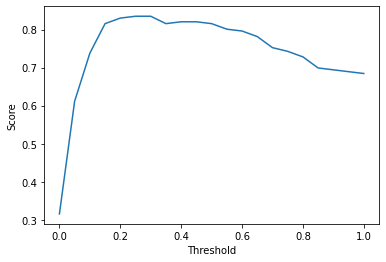

In [37]:
import matplotlib.pyplot as plt
plt.plot(threshold,score)
plt.xlabel('Threshold')
plt.ylabel('Score')
print('Max score:', np.max(score))
itemindex = np.where(score ==  np.max(score))
print('Correspoding threshold value:', threshold[itemindex[0][0]])

- As discussed earlier, when we set the threshold to 1.0, the accuracy between the model and testing set is equal to the percentage of entries considered bad concrete in the testing set

In [38]:
accuracy_score(y_test,(y_pred >= 1))

0.6844660194174758

- On the other hand, setting threshold to 0 will say all concretes are good, so comparing accuracy to testing set will simply pick out the percentage of concretes that are actually considered good from the testing set

In [39]:
accuracy_score(y_test,(y_pred >= 0))

0.3155339805825243

In [40]:
accuracy_score(y_test,(y_pred >= 0))+accuracy_score(y_test,(y_pred >= 1))

1.0

## You need to be careful when using accuracy as a measure of how good your model is
- Like above, we show that our model can give us decent percent agreement when we simply say to consider all concrete as bad
- It picks out the number of concretes that are truly considered bad, but if most concretes are considered bad in our dataset, we will get a high percentage agreement between model and actual
- But your model is obviously terrible here since it doesnt even do anything, you just set it to say all concrete is bad
- Your model is never correct for entries that are considered good concrete
- Pretty bad model, but gave high accuracy, a pit fall!

# Notes of confusion table and matrix

In [2]:
actual_positive = (y_test == 1)
actual_negative = (y_test == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [47]:
# here we find the total number of entries that match and are
# both POSITIVE between our prediction for positives, and actual for positives
# in other words, this is the number of TRUE POSITIVES

tp = (predict_positive & actual_positive).sum()

# on the other hand, we can find the total number of negatives that
# we predicted correctly. This is the number of TRUE NEGATIVES

tn = (predict_negative & actual_negative).sum()
print('tn:', tn)
print('tp:', tp)

tn: 128
tp: 40


In [49]:
# now we can compute how many of the entries we predicted to be positive
# but turned out to actually be negative. FALSE POSITIVES

fp = (predict_positive & actual_negative).sum()

# Additionally, we can compute the number we thought would be negative
# but in the actual dataset they turned out to be positive
# FALSE NEGATIVES
fn = (predict_negative & actual_positive).sum()
print('fp:', fp)
print('fn:', fn)

fp: 13
fn: 25


- And now, the confusion matrix just organizes these values

In [50]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[128,  13],
       [ 25,  40]])

- All the values added up is just the total entries in dataset

In [52]:
print('values added up:', tp+tn+fp+fn)
print('lenght of testing set:', len(y_test))

values added up: 206
lenght of testing set: 206


In [57]:
# we can normalize the matrix, gives percents
confusion_perc = confusion_matrix / confusion_matrix.sum()
confusion_perc

array([[0.62135922, 0.0631068 ],
       [0.12135922, 0.19417476]])

- Our accuracy then is just the true positive and negative percents added together

In [59]:
print('accuracy from confusion matrix:', confusion_perc[0][0] + confusion_perc[1][1])
print('accuracy from sklearn:', accuracy_score(y_test,y_pred >= t))

accuracy from confusion matrix: 0.8155339805825242
accuracy from sklearn: 0.8155339805825242


## Exercise: Compute Confusion Matrix

In [136]:
actual_positive = y_test == 1
actual_negative = y_test == 0

In [138]:
t = 0.5
predict_positive = y_pred >= 0.5
predict_negative = y_pred < 0.5

In [3]:
# now we calculate the true positive amount
# and the true negative amount
# along with the false positive and negative amounts
# true means the amount our model predicted as correctly positive or negative
# false means the amount that we got wrong as positive or negative from our model
# remember, positive means tending towards a value of 1
# negative means tending towards value of 0

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[128,  13],
       [ 25,  40]])

## Exercise: Compute Precision and Recall

- Precision: Fraction of positive predictions that are correct
- So take number of positives you correctly predicted tp, divided by total number of entries you THOUGHT were positive (tp + fp)

In [4]:
p = tp/(tp+fp)
p

0.7547169811320755

- Look at fraction of correctly identified positive entries
- So the number of entries we correctly predicted as positive tp, divided by the total number of entries that are ACTUALLY positive (tp + fn)

In [5]:
r = tp/(tp+fn)
r

0.6153846153846154

- COmpare this to our accuracy in general

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred >= t)

0.8155339805825242

- So, we see how our accuracy says our model is pretty good
- But our precision and recall are not as high
- So the model is not as good at identifing and getting positives correct as we might think from accuracy alone

# Implement ROC curve

- We did our data set reading above, well before this

- false positive rate = fp / (tn + fp)
 - tn + fp is the total number of actual negative entries
- true positive rate = tp / (fn + tp)
 - fn + tp is the total number of actual positive entries

- Now plot these guys with respect to threshold
- threshold being what value and above we take as meaning good concrete from our predicted model values between 0 and 1

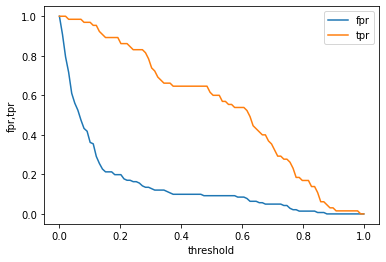

In [19]:
def tpr_fpr_dataframe(y_val, y_pred):
    threshold = np.linspace(0,1,100)
    fpr_list = []
    tpr_list = []
    for i in threshold:
        t = i
        predict_positive = y_pred >= t
        predict_negative = y_pred < t
        actual_positive = y_val == 1
        actual_negative = y_val == 0
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        fpr_list.append(fp/(tn+fp))
        tpr_list.append(tp/(fn+tp))
    return fpr_list, tpr_list, threshold



fpr_list, tpr_list, threshold = tpr_fpr_dataframe(y_test, y_pred)
plt.plot(threshold,fpr_list,label='fpr')
plt.plot(threshold,tpr_list,label='tpr')
plt.xlabel('threshold')
plt.ylabel('fpr,tpr')
plt.legend()

- let's look at what a random model is like

In [16]:
# random model
np.random.seed(50)
y_rand = np.random.uniform(0,1,size=len(y_test))
((y_rand >= 0.5) == y_test).mean()
# shows that our model is random, gets an accuracy of 50 percent from each
# entry being randomly chosen between 0 and 1

0.5145631067961165

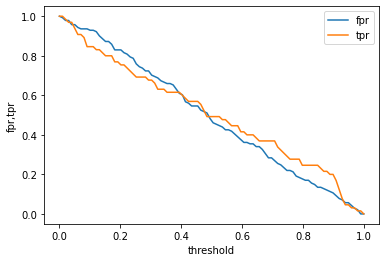

In [17]:
fpr_list_rand, tpr_list_rand, threshold = tpr_fpr_dataframe(y_test, y_rand)

# random model gives us straight lines for fpr and tpr vs threshold
plt.plot(threshold,fpr_list_rand,label='fpr')
plt.plot(threshold,tpr_list_rand,label='tpr')
plt.xlabel('threshold')
plt.ylabel('fpr,tpr')
plt.legend()

- Now let's look at what an ideal model is like
- the ideal model means that the entries are ordered such that all are truly negative until you hit a certain threshold. Afterwards, all are truly positive. So there is a distinct boundary between negative and positive entries in the list, making it perfectly predictable when you know what threshold is the boundary

In [7]:
num_neg = (y_test == 0).sum()
num_pos = (y_test == 1).sum()
num_neg, num_pos

(141, 65)

In [8]:
# this here is the threshold boundary
1-y_test.mean()

0.6844660194174756

In [9]:
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal_pred = np.linspace (0, 1, len(y_test))
((y_ideal_pred >= 1-y_test.mean()) == y_ideal).mean()

1.0

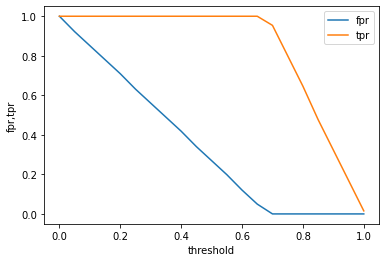

In [10]:
fpr_list_ideal, tpr_list_ideal, threshold = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

# random model gives us straight lines for fpr and tpr vs threshold
plt.plot(threshold,fpr_list_ideal,label='fpr')
plt.plot(threshold,tpr_list_ideal,label='tpr')
plt.xlabel('threshold')
plt.ylabel('fpr,tpr')
plt.legend()

- So we are able to maximize tpr and completely minimize fpr with the ideal model when the threshold is set to the boundary value

- Now we can plot these guys against each other (tpr vs fpr)

<Figure size 360x360 with 0 Axes>

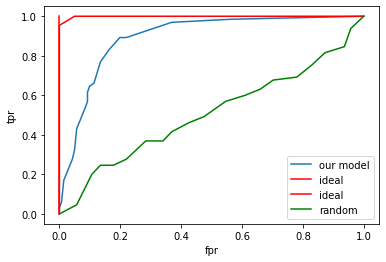

<Figure size 360x360 with 0 Axes>

In [28]:
plt.plot(fpr_list,tpr_list,label='our model')
plt.plot(fpr_list_ideal,tpr_list_ideal,label='ideal',color='red')
plt.plot(threshold*0,threshold,label='ideal',color='red')
plt.plot(fpr_list_rand,tpr_list_rand,label='random',color='green')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.figure(figsize=(5,5))

- This model is in between the ideal model and the random model curves
- random model, in limit of infinite entries, is just a linear line, seen above in green
- Ideal model gives us two lines, seen above in red, one vertical one horizontal

## Calculate AUC

- Now we can caluclate the area under each curve as a metric to compare
- Ideal model gives us exactly 1 as the area (in limit of infinite entries)
- random model gives us exactly 0.5 as the area (in limit of infinite entries)
- so our model will give something in between

In [20]:
model_roc_area = -np.trapz(tpr_list, x = fpr_list)
model_roc_area 

0.8970540098199673

In [21]:
# another way with sklearn
# this auc function can be used with ANY functions, not just tpr and fpr area

from sklearn.metrics import auc
auc(fpr_list, tpr_list)

0.8970540098199673

- So we actually tend towards the ideal model quite a bit more than the random model, which is good

In [22]:
# for the ideal model...
# should be essentially = 1

auc(fpr_list_ideal, tpr_list_ideal)

0.9988543371522094

In [23]:
# and here is a nice sklearn shortcut

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.8972176759410802

- AUC is the probability that you will randomly select a positive example that has a score higher (as determined by the model) than a randomly selected negative example
- So basically when your model is the ideal model, you will always choose a positive example that has a higher score than a negative example, since in the ideal model the examples are perfectly ordered to where there is an exact threshold boundary between the groupings of negative and positive examples

# Exercise: Use Gaussian Processes Regressor on Concrete Data

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

df=pd.read_csv('./Concrete_Data_Yeh.csv')

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=31,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=20,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.csMPa.values
y_val = df_val.csMPa.values
y_test = df_test.csMPa.values

del df_train['csMPa']
del df_val['csMPa']
del df_test['csMPa']

base = ['cement', 'slag','flyash', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def rmse(y, y_pred):
    # for each predicted value, find difference between it and actual
    error = y_pred - y
    # now square this error, and calculate the mean
    mse = (error**2).mean()
    # return the squar-rooted mse
    return np.sqrt(mse)

X_test = prepare_X(df_test)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

print(len(X_test), len(X_train), (len(X_val)))

206 618 206


- dataset is read in, now let's train the GPR

In [44]:
import sklearn.gaussian_process as gp
from sklearn.model_selection import GridSearchCV

kernel = gp.kernels.RBF(length_scale = 27, length_scale_bounds = (1e-03,1e03))
#parameters={'length_scale':[1,2,3,4,5,6]}
gpr = gp.GaussianProcessRegressor(kernel=kernel, random_state=1, optimizer= None,n_restarts_optimizer=10)
#gpr_search = GridSearchCV(gpr,parameters,cv=5)
gpr.fit(X_train, y_train)
print('Optimum length scale: ', gpr.kernel_.get_params()['length_scale'])

Optimum length scale:  27.0


In [45]:
# now make the prediction
prediction_test = gpr.predict(X_test)
prediction_train = gpr.predict(X_train)
prediction_val = gpr.predict(X_val)

print(rmse(y_val, prediction_val))
print(rmse(y_train, prediction_train))
print(rmse(y_test, prediction_test))

21.947050203832653
1.1174373277106007
21.208172059037807


- Looks like we are overfitting
- I can't seem to get the rmse below 17, even when I set the optimizer parameter to none and set the length scale on my own. Usually requires a much larger length scale than the one found by the optimizer to get the rmse lower.
- This may have something to do with including uncertainty in the dataset
- Maybe you need to include error explicitely
- We are not entirely sure about this per the campuswire post "Overfitting GPR"

- from the documentation, concerning the alpha parameter that can be included in fitting...
- "It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations"
- so maybe we should provide the variance of our training set

In [55]:
noise_std = y_train.std()

kernel = gp.kernels.RBF(length_scale = 1, length_scale_bounds = (1e-02,1e02))
#parameters={'length_scale':[1,2,3,4,5,6]}
gpr = gp.GaussianProcessRegressor(kernel=kernel, random_state=1 ,alpha=noise_std**2,n_restarts_optimizer=10)
#gpr_search = GridSearchCV(gpr,parameters,cv=5)
gpr.fit(X_train, y_train)
print('Optimum length scale: ', gpr.kernel_.get_params()['length_scale'])

Optimum length scale:  100.00000000000004


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [56]:
noise_std

16.5437958058953

In [57]:
prediction_test = gpr.predict(X_test)
prediction_train = gpr.predict(X_train)
prediction_val = gpr.predict(X_val)

print(rmse(y_val, prediction_val))
print(rmse(y_train, prediction_train))
print(rmse(y_test, prediction_test))

34.90323000347242
33.660505008430114
32.60833876685374


- At least now we have no overfitting, but our fit in general is not very good
- not too sure where to go from here

# Notes 4/4

- Here we are preparing some data from a bank about whether people may default or not on loans

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

df=pd.read_csv('./CreditScoring[1].csv')

In [41]:
df.columns = df.columns.str.lower()
df.status = df.status.map({1: 'ok', 2: 'default', 0: 'unknown'})
df.home = df.home.map({1: 'rent', 2: 'owner', 3: 'private', 4: 'ignore', 5: 'parents',
                       6: 'other', 0: 'unknown'})
df.marital = df.marital.map({1: 'single', 2: 'married', 3: 'widow', 4: 'separated',
                             5: 'divorced', 0: 'unknown'})
df.records = df.records.map({1: 'no', 2: 'yes', 0: 'unknown'})
df.job = df.job.map({1: 'fixed', 2: 'parttime', 3: 'freelance', 4: 'others', 0: 'unknown'})

In [42]:
# need to replace the 9999999 numbers, they mean those entries are missing
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value = np.nan).max()

In [43]:
# we dont care about unknown values in status
df = df[df.status != 'unknown'].reset_index(drop=True)

In [44]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 100)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 100)

In [45]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [46]:
# change the status values to integers, 0 for no default, 1 for yes defaults

y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values

In [47]:
del df_train['status']
del df_val['status']
del df_test['status']

## Decision Trees

In [48]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [49]:
# here we draw the records of the first entry in the list
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 1,
 'home': 'rent',
 'time': 36,
 'age': 37,
 'marital': 'married',
 'records': 'no',
 'job': 'parttime',
 'expenses': 75,
 'income': 959.0,
 'assets': 300000.0,
 'debt': 30000.0,
 'amount': 1100,
 'price': 1871}

In [50]:
# and we can assess the risk of loaning to this person
assess_risk(xi)

'ok'

In [51]:
# So they were determined to be ok to loan to by our model

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [53]:
# make a dictionary of the entries in training dataset
# need the dictionary vectorizer, since we have categorical data
train_dicts = df_train.to_dict(orient='records')
#train_dicts

In [54]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# so we have made all of our features categorical now
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unknown', 'income', 'job=fixed',
       'job=freelance', 'job=others', 'job=parttime', 'job=unknown',
       'marital=divorced', 'marital=married', 'marital=separated',
       'marital=single', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [57]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [215]:
# now do the same on the validation dataset to test our model
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [216]:
# our actual prediction on the validation dataset
# gives us 2d array, 2 values per prediction, take the second value for each
# second value is how much each person tends toward defaulting
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6337935174069629

- So not the greatest score, closer to random model rather than ideal model based on area underneath the roc curves

In [217]:
y_pred = dt.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.6029738906451235

- Still pretty bad for test dataset

In [218]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

- But it gives us 1 as area for training dataset, meaning it thinks we have ideal model
- We have overfitted our data
- the model memorizes the data, but fails to generalize to other datasets
- model sees specific entries and whether they defaulted, and believes then that those combinations of features will always result in whatever happened in the training dataset

- Why does this happen? If our decision tree grows too deep, the model gets stuck looking at very specific examples. It fails to see how the specific examples might relate to the dataset as a whole or other entries. Very similar to how you can overfit a scatter plot with a high degree polynomial. Polynomial fits the training dataset very closely, basically ignoring how specific points should not entirely define how the function looks in general at a certain location

- What we want to do is restrict the depth of our decision tree

In [219]:
# restrict the number of levels
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [220]:
y_pred = dt.predict_proba(X_train)[:,1]
print('train:', roc_auc_score(y_train, y_pred))

y_pred = dt.predict_proba(X_test)[:,1]
print('test:', roc_auc_score(y_test, y_pred))

y_pred = dt.predict_proba(X_val)[:,1]
print('val:', roc_auc_score(y_val, y_pred))

train: 0.7545747955175406
test: 0.7133272190349816
val: 0.7330511151829152


- Now this is looking much better

In [221]:
# here we find what rules our model followed to make its prections

from sklearn.tree import export_text

print(export_text(dt, feature_names = dv.get_feature_names()))

|--- seniority <= 2.50
|   |--- records=yes <= 0.50
|   |   |--- job=fixed <= 0.50
|   |   |   |--- class: 1
|   |   |--- job=fixed >  0.50
|   |   |   |--- class: 0
|   |--- records=yes >  0.50
|   |   |--- job=fixed <= 0.50
|   |   |   |--- class: 1
|   |   |--- job=fixed >  0.50
|   |   |   |--- class: 1
|--- seniority >  2.50
|   |--- records=no <= 0.50
|   |   |--- amount <= 865.00
|   |   |   |--- class: 0
|   |   |--- amount >  865.00
|   |   |   |--- class: 1
|   |--- records=no >  0.50
|   |   |--- job=parttime <= 0.50
|   |   |   |--- class: 0
|   |   |--- job=parttime >  0.50
|   |   |   |--- class: 0



C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Each feature name is given with the condition that the model used to determine each entry's status
- So for the first feature, it says that if the probability of the specific person having records = no is less than 50 percent (categorical), move to the next condition
- The next feature is numerical, the seniority. If it is less than 6.5 move to next condition in branch

# Decision tree learning algorithm

- Let's find what the best threshold for each condition should be

In [222]:
# here is an example dataset taken from our bank loans dataset that can help
# illustrate how we choose our conditional thresholds for the decision tree
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns = ['assets', 'status'])
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


- where should we split this dataset? what value of assets should be used as the threshold, where the data is split?

In [223]:
# this guy lets us print output within a for statement
from IPython.display import display

# here are the potential thresholds we could use
Ts = [0,2000,3000,4000,5000,8000]
# let's try out each

for T in Ts:
    df_right = df_example[df_example.assets > T]
    df_left = df_example[df_example.assets <= T]
    
    #display each dataset for each threshold, along with percentages for each status type
    display(df_left)
    print(df_left.status.value_counts(normalize = True))
    display(df_right)
    print(df_right.status.value_counts(normalize = True))

,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64


- For each split, look at the right and left datasets. The dataset on the left should, for this example dataset, have all entries are default status in the ideal case. So, count the number that are not defaulting, and use this percentage as your misclassification rate.
- Do the same for the right dataset, but this time ideal case is all should be ok status. Find the misclassification percentage
- These percentages help you know the quality of your split. Cross validate!
- Take the average of the misclassification values for each threshold split (so the average of two percentages). The threshold with the lowest average here is the best

- Add a new feature now, debt

In [224]:
# now let's add another feature, debt

data = [
    [8000,3000, 'default'],
    [2000,1000, 'default'],
    [0,1000, 'default'],
    [5000,1000, 'ok'],
    [5000,1000, 'ok'],
    [4000,1000, 'ok'],
    [9000,500, 'ok'],
    [3000,2000, 'default'],
]
df_example = pd.DataFrame(data, columns = ['assets','debt', 'status'])
df_example.sort_values('assets')

,assets,debt,status
2,0,1000,default
1,2000,1000,default
7,3000,2000,default
5,4000,1000,ok
3,5000,1000,ok
4,5000,1000,ok
0,8000,3000,default
6,9000,500,ok


In [225]:
# so we can split the debt dataset at 500, 1000, 2000
# let's put our thresholds into a dictionary for both features
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [226]:
# now, we iterate through our thresholds list
# for each feature
# then we iterate through the threshold values for that given feature
for feature, Ts in thresholds.items():
    print('###########################')
    print(feature)
    for T in Ts:
        df_right = df_example[df_example[feature] > T]
        df_left = df_example[df_example[feature] <= T]
    
        #display each dataset for each threshold, along with percentages for each status type
        display(df_left)
        print(df_left.status.value_counts(normalize = True))
        display(df_right)
        print(df_right.status.value_counts(normalize = True))
    print('###########################')

###########################
assets


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64
###########################
###########################
debt


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64
###########################


- Now, once again, go through and calculate the average between the two misclassification percentages from each dataset threshold split. Compare them to find the best threshold (lowest average value) for the features you are splitting for

- If you go through for this specific dataset you will find that the debt feature is not as good at splitting our dataset as the assets feature (it has higher average values for the misclassification percentages)

- So, now we need to figure out when to stop splitting our dataset and testing conditions
- If we let the tree go as deep as it wants, it will cause overfitting to the dataset
## Stopping Criteria
- if one of the split groups is pure (only one value for the targeted feature shows up among all the entries) then you stop, don't split that group again
- Tree reached depth limit
- Stop when group becomes too small to split (you set this limit)

## Decision Trees parameter tuning

- selecting max_depth
- selecting min_samples_leaf

In [227]:
# find our best depth for our example dataset from the bank loan dataset
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d,auc))

   1 -> 0.663
   2 -> 0.701
   3 -> 0.733
   4 -> 0.763
   5 -> 0.765
   6 -> 0.732
  10 -> 0.654
  15 -> 0.633
  20 -> 0.614
None -> 0.628


In [228]:
# looks like 4,5,6 are about the best values
# let's go through each of these and find the best minimum number of entries in each leaf (datasplit)
# the minimum leaf samples tells us how small a dataset can get before we don't split it anymore

scores = []

for d in [4,5,6]:
    for s in [1,2,5,10,15,20,45,100,200,500]:
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf = s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d,s,auc))
        print('(%4s, %3d) -> %.3f' % (d,s,auc))

(   4,   1) -> 0.763
(   4,   2) -> 0.763
(   4,   5) -> 0.763
(   4,  10) -> 0.764
(   4,  15) -> 0.765
(   4,  20) -> 0.765
(   4,  45) -> 0.767
(   4, 100) -> 0.779
(   4, 200) -> 0.755
(   4, 500) -> 0.708
(   5,   1) -> 0.765
(   5,   2) -> 0.765
(   5,   5) -> 0.769
(   5,  10) -> 0.772
(   5,  15) -> 0.779
(   5,  20) -> 0.778
(   5,  45) -> 0.779
(   5, 100) -> 0.783
(   5, 200) -> 0.759
(   5, 500) -> 0.708
(   6,   1) -> 0.729
(   6,   2) -> 0.737
(   6,   5) -> 0.751
(   6,  10) -> 0.771
(   6,  15) -> 0.780
(   6,  20) -> 0.779
(   6,  45) -> 0.774
(   6, 100) -> 0.785
(   6, 200) -> 0.759
(   6, 500) -> 0.708


In [229]:
# here is an easier way to view this data, in order of auc value

df_scores = pd.DataFrame(scores, columns = ['max_depth', 'min_samples_leaf','auc'])
df_scores = df_scores.sort_values(by='auc', ascending=False)
df_scores.head()

,max_depth,min_samples_leaf,auc
27,6,100,0.784858
17,5,100,0.783421
24,6,15,0.780306
16,5,45,0.779355
14,5,15,0.779118


In [230]:
df_scores_pivot=df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.763  0.765  0.729
2                 0.763  0.765  0.737
5                 0.763  0.769  0.751
10                0.764  0.772  0.771
15                0.765  0.779  0.780
20                0.765  0.778  0.779
45                0.767  0.779  0.774
100               0.779  0.783  0.785
200               0.755  0.759  0.759
500               0.708  0.708  0.708

- So now, take the max depth and minimum sample leaf values for the best auc (highest auc)
- Use this for your model fitting

In [232]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# Exercise: Use decision tree on Concrete data

- First we need to load in our data and get it ready for regression

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

df=pd.read_csv('./Concrete_Data_Yeh.csv')

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=104,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.csMPa.values
y_val = df_val.csMPa.values
y_test = df_test.csMPa.values

del df_train['csMPa']
del df_val['csMPa']
del df_test['csMPa']

base = ['cement', 'slag','flyash', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def rmse(y, y_pred):
    # for each predicted value, find difference between it and actual
    error = y_pred - y
    # now square this error, and calculate the mean
    mse = (error**2).mean()
    # return the squar-rooted mse
    return np.sqrt(mse)

X_test = prepare_X(df_test)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

- Now we do our decision tree regression. We will cross validate for values of max_depth (the max number of times our tree branches itself along a path) and min_samples_leaf (the minimum number of samples required in a leaf of the tree to allow for another split to be made).

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeRegressor(random_state=0)
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,15,20,25,30,40], 
              'min_samples_leaf':[1,2,3,4,10,15,30,60,100,250,500]}
decision_regressor = GridSearchCV(regressor,parameters,scoring='neg_mean_squared_error',cv=5)
decision_regressor.fit(X_train,y_train)
print(decision_regressor.best_params_)
print(math.sqrt(-1.0*decision_regressor.best_score_))

{'max_depth': 9, 'min_samples_leaf': 2}
7.528652877341291


In [3]:
# we can get the rmse for each of these

y_pred = decision_regressor.predict(X_train)
print('train:', rmse(y_train, y_pred))

y_pred = decision_regressor.predict(X_test)
print('test:', rmse(y_test, y_pred))

y_pred = decision_regressor.predict(X_val)
print('val:', rmse(y_val, y_pred))

train: 3.2002484424245234
test: 7.473684334195318
val: 7.443568778342521


- The decision tree regressor did a very good job, looks better than linear regression

- Let's try using the decision tree classifier now, instead of regressor
- this requires our response values be categorical instead of continuous
- Let's define good concrete, once again, by having a certain csMPa value or higher

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

df=pd.read_csv('./Concrete_Data_Yeh.csv')

df['goodconcrete']=(df.csMPa>45.0).astype(int)
# now delete the actual values for csMPa
# the target values are now categorical
del df['csMPa']

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=104,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.goodconcrete.values
y_val = df_val.goodconcrete.values
y_test = df_test.goodconcrete.values

del df_train['goodconcrete']
del df_val['goodconcrete']
del df_test['goodconcrete']

base = ['cement', 'slag','flyash', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

X_test = prepare_X(df_test)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [9]:
# this would help make variables categorical, but we only have continuous variables
# besides the good concrete variable. Therefore this doesnt do much

from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.fit_transform(test_dicts)
X_val = dv.fit_transform(val_dicts)

# so we have made all of our features categorical now
dv.get_feature_names_out()

array(['age', 'cement', 'coarseaggregate', 'fineaggregate', 'flyash',
       'slag', 'superplasticizer', 'water'], dtype=object)

- Here we use gridsearchcv to assist in cross validation, just like with the regressor
- Remember, the outcome here depends on what choice of threshold I used in determining what was good and bad concrete based on csMPa values

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,15,20,25,30,40], 
              'min_samples_leaf':[1,2,3,4,10,15,30,60,100,250,500]}

decision_classifier = GridSearchCV(regressor,parameters,scoring='roc_auc',cv=5)
decision_classifier.fit(X_train,y_train)
print(decision_classifier.best_params_)
print(decision_classifier.best_score_)

{'max_depth': 5, 'min_samples_leaf': 3}
0.916345522647411


- here are our auc values for each dataset

In [3]:
from sklearn.metrics import roc_auc_score

y_pred = decision_classifier.predict_proba(X_train)[:,1]
print('train:', roc_auc_score(y_train, y_pred))

y_pred = decision_classifier.predict_proba(X_test)[:,1]
print('test:', roc_auc_score(y_test, y_pred))

y_pred = decision_classifier.predict_proba(X_val)[:,1]
print('val:', roc_auc_score(y_val, y_pred))

train: 0.9770212145512867
test: 0.930278232405892
val: 0.8853881278538813


# Implement Random Forest

- Random forests are comprised of a number of decision trees
- Each tree is applied to a subset of the dataset
- This let's us optimize our predictive accuracy using averaging
- Also helps to control overfitting

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

df=pd.read_csv('./Concrete_Data_Yeh.csv')

df['goodconcrete']=(df.csMPa>45.0).astype(int)
# now delete the actual values for csMPa
# the target values are now categorical
del df['csMPa']

# split data using sklearn

# now assign the train and test data
df_train_full, df_test = train_test_split(df, random_state=104,test_size=0.20, shuffle=True)

# we now need to now split df_train_full into separate train and validation
df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
df_val.index

# move target values out
y_train = df_train.goodconcrete.values
y_val = df_val.goodconcrete.values
y_test = df_test.goodconcrete.values

del df_train['goodconcrete']
del df_val['goodconcrete']
del df_test['goodconcrete']

base = ['cement', 'slag','flyash', 'water', 'age', 'superplasticizer', 'coarseaggregate', 'fineaggregate']

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

X_test = prepare_X(df_test)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [60]:
rf = RandomForestClassifier(n_estimators = 10,random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [63]:
y_pred_val = rf.predict_proba(X_val)[:,1]
y_pred_train = rf.predict_proba(X_train)[:,1]

In [64]:
from sklearn.metrics import roc_auc_score
print('validation:' , roc_auc_score(y_val,y_pred_val))
print('train:' , roc_auc_score(y_train,y_pred_train))

validation: 0.935445205479452
train: 0.9995990376904571


- below we demonstrate how increasing number of trees generally leads to increase in auc

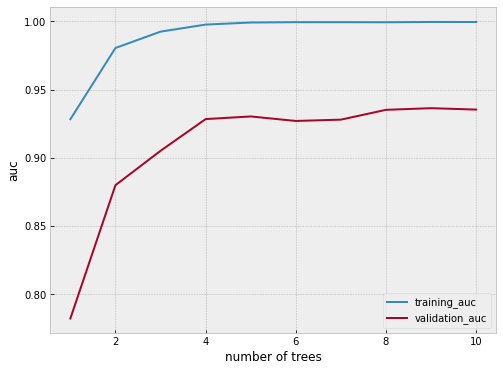

In [76]:
training_auc = []
validation_auc = []
num_trees = np.array([1,2,3,4,5,6,7,8,9,10])
for i in num_trees:
    rf = RandomForestClassifier(n_estimators = i,random_state=0)
    rf.fit(X_train, y_train)
    training_auc = np.append(training_auc, 
                             roc_auc_score(y_train,rf.predict_proba(X_train)[:,1]))
    validation_auc = np.append(validation_auc, 
                              roc_auc_score(y_val,rf.predict_proba(X_val)[:,1]))

plt.plot(num_trees, training_auc, label='training_auc')
plt.plot(num_trees, validation_auc, label='validation_auc')
plt.ylabel('auc')
plt.xlabel('number of trees')
plt.legend()

- Now let's try to optimize the parameters for each tree in the forest using gridsearchcv

In [28]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators = 10,random_state=0)

parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,15,20,25,30,40], 
              'min_samples_leaf':[1,2,3,4,10,15,30,60,100,250,500]}

rf_classifier = GridSearchCV(rf,parameters,scoring='roc_auc',cv=5)
rf_classifier.fit(X_train,y_train)
print(rf_classifier.best_params_)
print(rf_classifier.best_score_)

{'max_depth': 7, 'min_samples_leaf': 1}
0.9696208054987064


In [30]:
y_pred = rf_classifier.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.9456621004566209

- Looks like we got a bit of a better auc

# Exercise: Implement Gradient Boosting

- For this, make sure to use an environment with xgboost installed

In [1]:
import xgboost as xgb

In [4]:
# following the ML course, we will go ahead and vectorize our data

from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.fit_transform(test_dicts)
X_val = dv.fit_transform(val_dicts)

# so we have made all of our features categorical now
dv.get_feature_names_out()

array(['age', 'cement', 'coarseaggregate', 'fineaggregate', 'flyash',
       'slag', 'superplasticizer', 'water'], dtype=object)

In [5]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [6]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=20)

In [7]:
y_pred = model.predict(dval)

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred)

0.9606735159817351

In [ ]:
scores={}

In [36]:
%%capture output

watchlist = [(dtest, 'test'),(dval, 'val'),(dtrain, 'train')]
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals = watchlist)

In [37]:
s=output.stdout
line = s.split('\n')[0]
num_iter, test_auc, val_auc, train_auc = line.split('\t')

In [43]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_test = []
    aucs_val = []
    aucs_train = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, test_line, val_line, train_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        test = float(test_line.split(':')[1])
        val = float(val_line.split(':')[1])
        train = float(train_line.split(':')[1])
        
        results.append((it, test, val, train))
        tree.append(it)
        aucs_test.append(test)
        aucs_val.append(val)
        aucs_train.append(train)
    
    columns = ['num_iter', 'test_auc', 'val_auc', 'train_auc']
    df_results= pd.DataFrame(results, columns = columns)
        
    return df_results

- Below we capture the outputs for different etas (which we obtained by manually changing eta in the cells above a few times to different values)

In [44]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

- So now scores has the output values from our function from above, along with the eta values that go along with each output

In [45]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1', 'eta=0.05', 'eta=0.1'])

- Before we do anything with this, let's make another variable that is just the output of a single eta value

In [46]:
df_score = parse_xgb_output(output)

- And plot all of the fits for test, train, validation

(0.896796, 1.01)

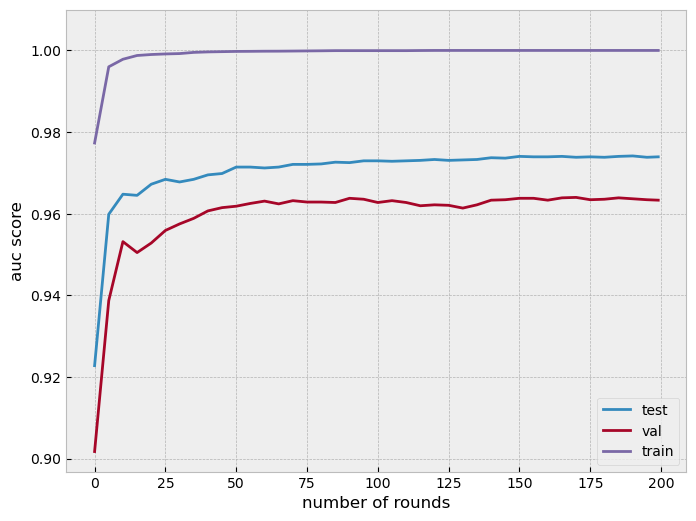

In [47]:
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,6)
title_size=24

plt.plot(df_score.num_iter, df_score.test_auc, label='test')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.xlabel('number of rounds')
plt.ylabel('auc score')
plt.legend()
plt.ylim(ymax=1.01)

- The overfit is the gap between our test line and the other lines

- now we use the scores array we created. Remember, it contains multiple outputs with the eta value for each. Let's go ahead and plot just the validation outputs, labeling each output based on eta. This can help us see how eta affects learning

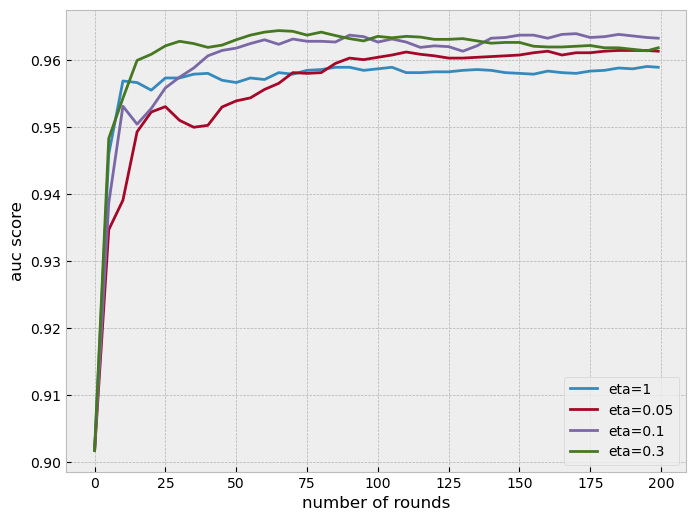

In [50]:
etas = ['eta=1','eta=0.05','eta=0.1','eta=0.3']

for eta in etas:
    df_score=scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label = eta)
plt.xlabel('number of rounds')
plt.ylabel('auc score')
plt.legend()

- We see from this that we need to strike a balance between higher and lower learning rate. Too low of a learning rate and we never reach the higher auc values. Too fast of learning rate and we reach higher auc values quickly but then level off fast at values that aren't as high as we could get. Eta of 0.3 or 0.1 seem to be pretty good. 0.3 may be the best since it quickly gets us to the highest value among all the etas.

# Neural Networks

 - How are they trained? backpropagation

# Logistic Regression Bow Tie

- Descriptors asked for:
- Day of week
- day of month
- 'weather' (precipitation seems to have high correlation)
- shirt color
- phone battery

In [168]:
# read in our bow tie data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df=pd.read_csv('./Bow_Tie_Machine_Learning.csv')

In [169]:
df.columns = df.columns.str.replace(' ', '_')
del df['Date']
del df['Month']
#del df['Day_of_Month']
del df['Weather_Current']
#df['Bow_Tie'] = df['Bow_Tie'].replace({True: 'yes', False: 'no'})
df.head()

,Day_of_Month,Day_of_Week,Phone_Battery,Shirt_Color,Weather_High,Weather_Low,Wind_Speed_(12pm),Humidity_(12pm),Dew_Point,Wind_Speed_(1am),Max_Wind_Speed,Precipitation,Bow_Tie
0,17,Tuesday,65,Blue,46,32,15,79,35.21,13,20,0.17,True
1,19,Thursday,100,Other,42,29,26,82,36.87,0,30,0.57,True
2,24,Tuesday,86,Blue,40,32,6,76,30.04,9,9,0.00,True
3,26,Thursday,87,Grey,25,17,24,84,20.33,17,24,0.20,True
4,31,Tuesday,43,Grey,21,10,7,45,1.67,14,14,0.00,False


In [170]:
# find the correlation for numerical features

numerical = ['Phone_Battery','Weather_High', 'Weather_Low', 'Dew_Point', 
             'Max_Wind_Speed', 'Precipitation','Humidity_(12pm)','Day_of_Month','Wind_Speed_(1am)','Wind_Speed_(12pm)']
df[numerical].corrwith(df.Bow_Tie).to_frame('correlation')

,correlation
Phone_Battery,0.188708
Weather_High,-0.351684
Weather_Low,-0.196676
Dew_Point,0.114394
Max_Wind_Speed,0.197141
Precipitation,0.554695
Humidity_(12pm),0.552850
Day_of_Month,0.249811
Wind_Speed_(1am),0.005083
Wind_Speed_(12pm),0.371768


In [171]:
# find the mutual information for the categorical features

categorical = ['Day_of_Week','Shirt_Color']

from sklearn.metrics import mutual_info_score
# it can be useful to define a function for this
def calculate_mi(series):
    return mutual_info_score(series, df.Bow_Tie)

# we can enact our function on a subset of data with '.apply(calculate_mi)'
df_mi = df[categorical].apply(calculate_mi)
#df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

Day_of_Week    0.068765
Shirt_Color    0.000890
dtype: float64

In [172]:
# now we use the above to choose which features to keep...

del df['Shirt_Color']
del df['Wind_Speed_(1am)']
del df['Dew_Point']
del df['Weather_Low']

In [173]:
# Since our dataset is pretty short, let's just do a single split in the data
# split into training and test datasets
df_train, df_test = train_test_split(df, random_state=30,test_size=0.50, shuffle=True)

df_train_full = df_train.copy()
# we now need to now split df_train_full into separate train and validation
#df_train, df_val = train_test_split(df_train_full, random_state=100,test_size=0.25, shuffle=True)
#df_val.index

# move target values out
y_train = df_train.Bow_Tie.values
#y_val = df_val.Bow_Tie.values
y_test = df_test.Bow_Tie.values

y_all = df.Bow_Tie.values

del df_train['Bow_Tie']
#del df_val['Bow_Tie']
del df_test['Bow_Tie']

base = ['Day_of_Week', 'Phone_Battery', 'Weather_High', 'Max_Wind_Speed', 
        'Precipitation', 'Humidity_(12pm)','Day_of_Month','Wind_Speed_(12pm)']
numerical = ['Phone_Battery','Weather_High', 'Max_Wind_Speed', 'Precipitation','Humidity_(12pm)','Day_of_Month','Wind_Speed_(12pm)']
categorical = ['Day_of_Week']

In [174]:
# one-hot encode

full_dict = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(full_dict)
X_full = dv.transform(full_dict)

feature_names = dv.get_feature_names_out()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test = dv.transform(test_dict)

feature_names

array(['Day_of_Month', 'Day_of_Week=Thursday', 'Day_of_Week=Tuesday',
       'Humidity_(12pm)', 'Max_Wind_Speed', 'Phone_Battery',
       'Precipitation', 'Weather_High', 'Wind_Speed_(12pm)'], dtype=object)

In [175]:
# let's start with a logistic regression model to predict bow tie data
# train the model on our training dataset
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

# here are the weights of each feature
print(model.coef_)
print(feature_names)

[[ 0.02972599  0.00565723 -0.01328528  0.26308592 -0.09851752  0.03685186
   0.00913832 -0.49281518  0.19478399]]
['Day_of_Month' 'Day_of_Week=Thursday' 'Day_of_Week=Tuesday'
 'Humidity_(12pm)' 'Max_Wind_Speed' 'Phone_Battery' 'Precipitation'
 'Weather_High' 'Wind_Speed_(12pm)']


In [176]:
# soft predictions

y_pred = model.predict_proba(X_test)[:, 1]
model.predict_proba(X_test)

array([[9.95205112e-01, 4.79488845e-03],
       [9.99999856e-01, 1.44437416e-07],
       [1.00000000e+00, 9.91225113e-12],
       [9.99969830e-01, 3.01702658e-05],
       [9.99981785e-01, 1.82147152e-05],
       [1.24875148e-01, 8.75124852e-01],
       [9.97998229e-01, 2.00177099e-03],
       [9.93384162e-01, 6.61583835e-03],
       [9.99869506e-01, 1.30494005e-04],
       [1.87209638e-02, 9.81279036e-01],
       [7.87067503e-03, 9.92129325e-01],
       [9.99999909e-01, 9.07654221e-08],
       [9.99946308e-01, 5.36915033e-05],
       [3.81395505e-03, 9.96186045e-01]])

In [177]:
# Store the predictions of whether or not we expect bow tie
# meaning that the number in y_pred is > 0.5, tending towards 1 rather than 0

bow_tie = (y_pred >= 0.5)

# and let's see how our accuracy is
from sklearn.metrics import accuracy_score

accuracy_score(y_test, bow_tie)

0.7142857142857143

# Decision Tree Bow Tie

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df=pd.read_csv('./Bow_Tie_Machine_Learning.csv')

df.columns = df.columns.str.replace(' ', '_')
del df['Date']
del df['Month']
del df['Weather_Current']

# split data using sklearn

# now assign the train and test data
df_train, df_test = train_test_split(df, random_state=104,test_size=0.30, shuffle=True)

# move target values out
y_train = df_train.Bow_Tie.values
y_test = df_test.Bow_Tie.values

del df_train['Bow_Tie']
del df_test['Bow_Tie']

base = ['Day_of_Week', 'Phone_Battery', 'Shirt_Color', 'Weather_High', 'Weather_Low', 
       'Dew_Point', 'Max_Wind_Speed', 'Precipitation', 'Humidity_(12pm)','Day_of_Month','Wind_Speed_(1am)']
numerical = ['Phone_Battery','Weather_High', 'Weather_Low', 'Dew_Point', 
             'Max_Wind_Speed', 'Precipitation','Humidity_(12pm)','Day_of_Month','Wind_Speed_(1am)']
categorical = ['Day_of_Week','Shirt_Color']

train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test = dv.transform(test_dict)

,correlation
Phone_Battery,0.188708
Weather_High,-0.351684
Weather_Low,-0.196676
Dew_Point,0.114394
Max_Wind_Speed,0.197141
Precipitation,0.554695
Humidity_(12pm),0.552850
Day_of_Month,0.249811
Wind_Speed_(1am),0.005083


In [71]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators = 20,random_state=5)

parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,15,20,25,30,40], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9]}

rf_classifier = GridSearchCV(rf,parameters,scoring='roc_auc',cv=6)
rf_classifier.fit(X_train,y_train)
print(rf_classifier.best_params_)
print(rf_classifier.best_score_)

{'max_depth': 1, 'min_samples_leaf': 5}
1.0


In [72]:
y_pred = rf_classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.6666666666666666

# NEXT, try SVM, knn, single decision tree